In [1]:
import os
import glob

import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from pyLZJD import digest, sim


In [2]:
#First, lets check if we have the t5 corpus
if not (os.path.exists("t5-corpus.zip") or os.path.exists("t5") ):
	print("Downloading t5 dataset")
	import urllib.request
	urllib.request.urlretrieve('http://roussev.net/t5/t5-corpus.zip', 't5-corpus.zip')
	
	import zipfile
	with zipfile.ZipFile("t5-corpus.zip","r") as zip_ref:
		zip_ref.extractall(".")
		


In [3]:
#Lets collect up all the files in the t5 corpus. Its organized as one big folder, and the extension of each file tells us what kind of file it is. 
X_paths = glob.glob("t5/*")

labels_true = list(set([ x[x.find(".")+1:] for x in X_paths]))
print("Labels:", labels_true)
#Label every file based on which file type it was
Y = np.asarray([ labels_true.index(x[x.find(".")+1:]) for x in X_paths])



Labels: ['jpg', 'html', 'pdf', 'ppt', 'text', 'doc', 'gif', 'xls']


In [4]:
#Lets hash all the files now! We have a list of paths, pyLZJD can take that dirrectly and convert it to hashes
X_hashes = digest(X_paths, processes=-1)
print("Done hashing!")
#We are going to use some tools from scikit-learn. It needs a distance function between data stored as a list of vectors. 
#So we will create a list of 1-D vectors, each each vector sotres the index to it's hash in X_hashes
X = [ [i] for i in range(len(X_hashes))]



Done hashing!


In [10]:
#Now we define a distance function between two vectors in X. It accesses the index value, and computes the LZJD distance
def lzjd_dist(a, b):
	a_i = X_hashes[int(a[0])]
	b_i = X_hashes[int(b[0])]
	
	return 1.0-sim(a_i, b_i)


knn_model = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric=lzjd_dist)

scores = cross_val_score(knn_model, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))




Accuracy: 0.91 (+/- 0.01)


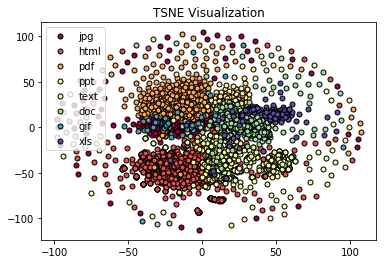

In [9]:
X_embedded = TSNE(n_components=2, perplexity=5, metric=lzjd_dist).fit_transform(X)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(labels_true))]
for k, col in zip([z for z in range(len(labels_true))], colors):
	if k == -1:
		# Black used for noise.
		col = [0, 0, 0, 1]

	class_member_mask = (Y == k)

	xy = X_embedded[class_member_mask]
	plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, label=labels_true[k])

plt.title('TSNE Visualization')
plt.legend(loc='upper left')
plt.savefig("t5_perp5.pdf")
plt.show()